<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/images/IDSNlogo.png" width="300" alt="cognitiveclass.ai logo"  />
</center>

<h1 align="center"><font size="5">Classification with Python</font></h1>


In this notebook we try to practice all the classification algorithms that we have learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Let's first load required libraries:


In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset


This dataset is about past loans. The **Loan_train.csv** data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
| -------------- | ------------------------------------------------------------------------------------- |
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |


Let's download the dataset


In [2]:
!wget -O loan_train.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv

--2021-08-21 19:14:26--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.63.118.104
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.63.118.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0s      

2021-08-21 19:14:27 (144 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File


In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object


In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing


Let’s see how many of each class is in our data set


In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection


Let's plot some columns to underestand data better:


In [7]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Solving environment: done

# All requested packages already installed.



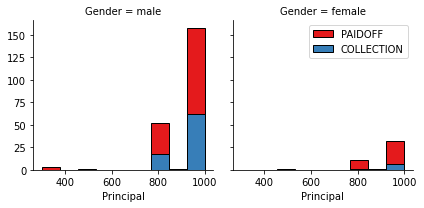

In [8]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

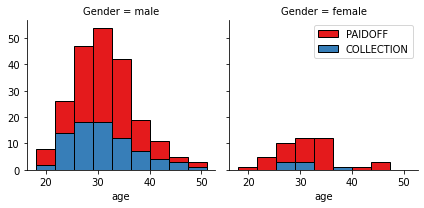

In [9]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction


### Let's look at the day of the week people get the loan


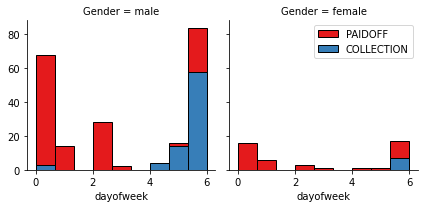

In [10]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week don't pay it off, so let's use Feature binarization to set a threshold value less than day 4


In [11]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values


Let's look at gender:


In [12]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Let's convert male to 0 and female to 1:


In [13]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding

#### How about education?


In [14]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Features before One Hot Encoding


In [15]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame


In [16]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature Selection


Let's define feature sets, X:


In [17]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?


In [18]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data


Data Standardization give data zero mean and unit variance (technically should be done after train test split)


In [19]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification


Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:

*   K Nearest Neighbor(KNN)
*   Decision Tree
*   Support Vector Machine
*   Logistic Regression

\__ Notice:\__

*   You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
*   You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
*   You should include the code of the algorithm in the following cells.


# K Nearest Neighbor(KNN)

Notice: You should find the best k to build the model with the best accuracy.\
**warning:** You should not use the **loan_test.csv** for finding the best k, however, you can split your train_loan.csv into train and test to find the best **k**.


In [20]:
#Train-Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [21]:
#Training
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

Ks = 12
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMtx=[];
for n in range(1,Ks):
    neigh = KNeighborsClassifier(n_neighbors=n).fit(X_train, y_train)
    yhat = neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)
    std_acc[n-1] = np.std(yhat==y_test)/np.sqrt(yhat.shape[0])
mean_acc

array([0.67142857, 0.62857143, 0.71428571, 0.72857143, 0.75714286,
       0.77142857, 0.72857143, 0.77142857, 0.72857143, 0.71428571,
       0.7       ])

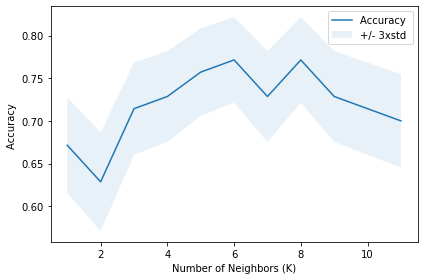

The best accuracy was with 0.7714285714285715 with k= 6


In [22]:
plt.plot(range(1,Ks),mean_acc)
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

neigh = KNeighborsClassifier(n_neighbors=mean_acc.argmax()+1).fit(X_train, y_train)

In [23]:
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1)

The best accuracy was with 0.7714285714285715 with k= 6


In [24]:
# Set value of k as 7
k = 7
# Train Model and Predict  
loanknn = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
loanknn

KNeighborsClassifier(n_neighbors=7)

In [25]:
yhat = loanknn.predict(X_test)
yhat[0:5]

array(['PAIDOFF', 'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'COLLECTION'],
      dtype=object)

In [26]:
print("Train set Accuracy: ", metrics.accuracy_score(y_train, loanknn.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))

Train set Accuracy:  0.7971014492753623
Test set Accuracy:  0.7285714285714285


In [27]:
from sklearn.metrics import classification_report

print (classification_report(y_test, yhat))

              precision    recall  f1-score   support

  COLLECTION       0.67      0.35      0.46        23
     PAIDOFF       0.74      0.91      0.82        47

    accuracy                           0.73        70
   macro avg       0.70      0.63      0.64        70
weighted avg       0.72      0.73      0.70        70



In [28]:
from sklearn.metrics import f1_score
f1_score(y_test, yhat, average='weighted')

0.7001360544217686

In [31]:
from sklearn.metrics import jaccard_score
print(jaccard_score(y_test, yhat, pos_label= "COLLECTION"))
print(jaccard_score(y_test, yhat, pos_label= "PAIDOFF"))

0.2962962962962963
0.6935483870967742


# Decision Tree


In [32]:
# Import the decision tree model

from sklearn.tree import DecisionTreeClassifier

In [33]:
md = 10
mean_acc = np.zeros((md-1))
std_acc = np.zeros((md-1))
ConfustionMx = [];
for n in range(1,md):
    
    #Train Model and Predict  
    loant = DecisionTreeClassifier(criterion="entropy", max_depth = n).fit(X_train,y_train)
    yhat=loant.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

array([0.67142857, 0.67142857, 0.67142857, 0.67142857, 0.67142857,
       0.67142857, 0.65714286, 0.7       , 0.68571429])

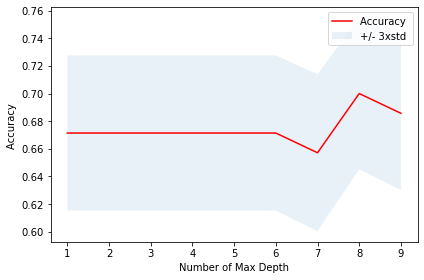

In [34]:
plt.plot(range(1,md),mean_acc,'r')
plt.fill_between(range(1,md),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Max Depth')
plt.tight_layout()
plt.show()

In [35]:
#Building the decision tree with max depth of 6
loandt = DecisionTreeClassifier(criterion="entropy", max_depth = 6)

# Check the default parameters
loandt 

# Train the Decision tree model
loandt.fit(X_train,y_train)

# Predict using the model
yhat= loandt.predict(X_test)

In [36]:
#Calculating the train and test accuracy
print("Train set Accuracy: ", metrics.accuracy_score(y_train, loandt.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))
#Building the confusion matrix
print (classification_report(y_test, yhat))

Train set Accuracy:  0.7971014492753623
Test set Accuracy:  0.6714285714285714
              precision    recall  f1-score   support

  COLLECTION       0.50      0.09      0.15        23
     PAIDOFF       0.68      0.96      0.80        47

    accuracy                           0.67        70
   macro avg       0.59      0.52      0.47        70
weighted avg       0.62      0.67      0.58        70



In [37]:
# Calculate the F1 score
f1_score(y_test, yhat, average='weighted')

0.5834433675141639

In [38]:
# Calculate the jaccard index
print(jaccard_score(y_test, yhat, pos_label= "COLLECTION"))
print(jaccard_score(y_test, yhat, pos_label= "PAIDOFF"))

0.08
0.6617647058823529


# Support Vector Machine


In [41]:
# Import the library for SVM Classifier
from sklearn import svm

# Build a SVM Classifier with a Radial base Function Kernel
loansvm1 = svm.SVC(kernel='rbf').fit(X_train, y_train)
yhat1 = loansvm1.predict(X_test)
svm_r = metrics.accuracy_score(y_test, yhat1)

# Build a SVM Classifier with a Linear Kernel
loansvm2 = svm.SVC(kernel='linear').fit(X_train, y_train)
yhat2 = loansvm2.predict(X_test)
svm_l = metrics.accuracy_score(y_test, yhat2)
    
# Build a SVM Classifier with a Polynomial Kernel
loansvm3 = svm.SVC(kernel='poly').fit(X_train, y_train)
yhat3 = loansvm3.predict(X_test)
svm_p = metrics.accuracy_score(y_test, yhat3)

# Build a SVM Classifier with a Sigmoid Kernel
loansvm4 = svm.SVC(kernel='sigmoid').fit(X_train, y_train)
yhat4 = loansvm4.predict(X_test)
svm_s = metrics.accuracy_score(y_test, yhat4)
    
print(svm_r,svm_l,svm_p,svm_s,sep="\n")


0.6714285714285714
0.6714285714285714
0.6714285714285714
0.6714285714285714


In [42]:
# Find if labels are missing in the SVM models 
print("The label missing in the first model with rbf kernel",set(y_test) - set(yhat1))
print("The label missing in the second model with linear",set(y_test) - set(yhat2))
print("The label missing in the third model with polynomial kernel",set(y_test) - set(yhat3))
print("The label missing in the fourth model with sigmoid kernel",set(y_test) - set(yhat4))

The label missing in the first model with rbf kernel {'COLLECTION'}
The label missing in the second model with linear {'COLLECTION'}
The label missing in the third model with polynomial kernel set()
The label missing in the fourth model with sigmoid kernel {'COLLECTION'}


In [43]:
# Build and train the SVM Classifier with a linear kernel

loansvm = svm.SVC(kernel='rbf').fit(X_train, y_train)

In [44]:
#Predicting the test values using the SVM model
yhat = loansvm.predict(X_test)
yhat [0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [45]:
print("Train set Accuracy: ", metrics.accuracy_score(y_train, loansvm.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))

print (classification_report(y_test, yhat))

Train set Accuracy:  0.7717391304347826
Test set Accuracy:  0.6714285714285714
              precision    recall  f1-score   support

  COLLECTION       0.00      0.00      0.00        23
     PAIDOFF       0.67      1.00      0.80        47

    accuracy                           0.67        70
   macro avg       0.34      0.50      0.40        70
weighted avg       0.45      0.67      0.54        70



/opt/conda/envs/Python-3.8-main/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [46]:
# Calculate the f1 score
f1_score(y_test, yhat, average='weighted')

0.5394383394383394

In [47]:
#Calculate the Jaccard index
print(jaccard_score(y_test, yhat, pos_label= "COLLECTION"))
print(jaccard_score(y_test, yhat, pos_label= "PAIDOFF"))

0.0
0.6714285714285714


# Logistic Regression


In [48]:
# Import the library for Logistice regression
from sklearn.linear_model import LogisticRegression

# Build and train the logestic regression model
loanlr1 = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
yhat1 = loanlr1.predict(X_test)
loanlr_a1 = metrics.accuracy_score(y_test, yhat1)

# Build and train the logestic regression model
loanlr2 = LogisticRegression(C=0.01, solver='sag').fit(X_train,y_train)
yhat2 = loanlr2.predict(X_test)
loanlr_a2 = metrics.accuracy_score(y_test, yhat2)

# Build and train the logestic regression model
loanlr3 = LogisticRegression(C=0.01, solver='saga').fit(X_train,y_train)
yhat3 = loanlr3.predict(X_test)
loanlr_a3 = metrics.accuracy_score(y_test, yhat3)

# Build and train the logestic regression model
loanlr4 = LogisticRegression(C=0.01, solver='newton-cg').fit(X_train,y_train)
yhat4 = loanlr4.predict(X_test)
loanlr_a4 = metrics.accuracy_score(y_test, yhat4)

# Build and train the logestic regression model
loanlr5 = LogisticRegression(C=0.01, solver='lbfgs').fit(X_train,y_train)
yhat5 = loanlr5.predict(X_test)
loanlr_a5 = metrics.accuracy_score(y_test, yhat5)


print('LR model with liblinear solver',loanlr_a1)
print('LR model with sag solver',loanlr_a2)
print('LR model with saga solver',loanlr_a3)
print('LR model with newton-cg solver',loanlr_a4)
print('LR model with lbfgs solver',loanlr_a5)

LR model with liblinear solver 0.6714285714285714
LR model with sag solver 0.6714285714285714
LR model with saga solver 0.6714285714285714
LR model with newton-cg solver 0.6714285714285714
LR model with lbfgs solver 0.6714285714285714


In [49]:
# Find if labels are missing in the models 
print("The label missing in the LR model with liblinear solver",set(y_test) - set(yhat1))
print("The label missing in the LR model with sag solver",set(y_test) - set(yhat2))
print("The label missing in the LR model with saga solver",set(y_test) - set(yhat3))
print("The label missing in the LR model with newton-cg solver",set(y_test) - set(yhat4))
print("The label missing in the LR model with lbfgs solver",set(y_test) - set(yhat5))

The label missing in the LR model with liblinear solver {'COLLECTION'}
The label missing in the LR model with sag solver {'COLLECTION'}
The label missing in the LR model with saga solver {'COLLECTION'}
The label missing in the LR model with newton-cg solver {'COLLECTION'}
The label missing in the LR model with lbfgs solver {'COLLECTION'}


In [50]:
#all model has skipped the lable "collection" from the predicted values. Hence, the best logistic classifier will be the one with a liblinear solver
loanlr = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
yhat = loanlr.predict(X_test)

In [51]:
print("Train set Accuracy: ", metrics.accuracy_score(y_train, loanlr.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))
print (classification_report(y_test, yhat))

Train set Accuracy:  0.7717391304347826
Test set Accuracy:  0.6714285714285714
              precision    recall  f1-score   support

  COLLECTION       0.00      0.00      0.00        23
     PAIDOFF       0.67      1.00      0.80        47

    accuracy                           0.67        70
   macro avg       0.34      0.50      0.40        70
weighted avg       0.45      0.67      0.54        70



/opt/conda/envs/Python-3.8-main/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [52]:
# Calculate the f1 score
f1_score(y_test, yhat, average='weighted')

0.5394383394383394

In [53]:
#Calculate the Jaccard index
print(jaccard_score(y_test, yhat, pos_label= "COLLECTION"))
print(jaccard_score(y_test, yhat, pos_label= "PAIDOFF"))

0.0
0.6714285714285714


# Model Evaluation using Test set


In [54]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss


First, download and load the test set:


In [55]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2021-08-21 19:41:18--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2021-08-21 19:41:20 (48.3 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation


In [56]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [57]:
# shape of the test data set 
test_df.shape

(54, 10)

In [58]:
# Count of the loan status 
test_df['loan_status'].value_counts()

PAIDOFF       40
COLLECTION    14
Name: loan_status, dtype: int64

In [59]:
df = test_df

df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df['dayofweek'] = df['effective_date'].dt.dayofweek
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)

df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)

df.groupby(['education'])['loan_status'].value_counts(normalize=True)

Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)

X_test = Feature

y_test = df['loan_status'].values

X_test = preprocessing.StandardScaler().fit(X_test).transform(X_test)

In [60]:
# KNN model testing
yhat_knn = loanknn.predict(X_test)

# Calculate the f1 score
f1_knn = f1_score(y_test, yhat_knn, average='weighted') 

#Calculate the Jaccard index# Predict using the model
jsc_knn_col = jaccard_score(y_test, yhat_knn, pos_label= "COLLECTION")
jsc_knn_paid = jaccard_score(y_test, yhat_knn, pos_label= "PAIDOFF")

print('f1 score: ',f1_knn)
print('Jaccard index: "COLLECTION" ',jsc_knn_col)
print('Jaccard index: "PAIDOFF" ',jsc_knn_paid)

f1 score:  0.7144311330357843
Jaccard index: "COLLECTION"  0.2222222222222222
Jaccard index: "PAIDOFF"  0.72


In [61]:
# Predict using the model
yhat_dt= loandt.predict(X_test)

# Calculate the f1 score
f1_dt = f1_score(y_test, yhat_dt, average='weighted') 

#Calculate the Jaccard index# Predict using the model
jsc_dt_col = jaccard_score(y_test, yhat_dt, pos_label= "COLLECTION")
jsc_dt_paid = jaccard_score(y_test, yhat_dt, pos_label= "PAIDOFF")

print('f1 score: ',f1_dt)
print('Jaccard index: "COLLECTION" ',jsc_dt_col)
print('Jaccard index: "PAIDOFF" ',jsc_dt_paid)

f1 score:  0.7861952861952862
Jaccard index: "COLLECTION"  0.3333333333333333
Jaccard index: "PAIDOFF"  0.7959183673469388


In [62]:
# Predict using the model
yhat_svm = loansvm.predict(X_test)

# Calculate the f1 score
f1_svm = f1_score(y_test, yhat_svm, average='weighted') 

#Calculate the Jaccard index# Predict using the model
jsc_svm_col = jaccard_score(y_test, yhat_svm, pos_label= "COLLECTION")
jsc_svm_paid = jaccard_score(y_test, yhat_svm, pos_label= "PAIDOFF")

print('f1 score: ',f1_svm)
print('Jaccard index: "COLLECTION" ',jsc_svm_col)
print('Jaccard index: "PAIDOFF" ',jsc_svm_paid)


f1 score:  0.6304176516942475
Jaccard index: "COLLECTION"  0.0
Jaccard index: "PAIDOFF"  0.7407407407407407


In [63]:
# Predict using the model
yhat_lr = loanlr.predict(X_test)

# Calculate the f1 score
f1_lr = f1_score(y_test, yhat_lr, average='weighted') 

#Calculate the Jaccard index# Predict using the model
jsc_lr_col = jaccard_score(y_test, yhat_lr, pos_label= "COLLECTION")
jsc_lr_paid = jaccard_score(y_test, yhat_lr, pos_label= "PAIDOFF")

# Calculate Log loss
yhat_lr_prob = loanlr.predict_proba(X_test)
ll_lr = log_loss(y_test, yhat_lr_prob)


print('f1 score: ',f1_lr)
print('Jaccard index: "COLLECTION" ',jsc_lr_col)
print('Jaccard index: "PAIDOFF" ',jsc_lr_paid)
print('Log Loss: ',ll_lr)

f1 score:  0.6304176516942475
Jaccard index: "COLLECTION"  0.0
Jaccard index: "PAIDOFF"  0.7407407407407407
Log Loss:  0.5716299706385595


# Report

You should be able to report the accuracy of the built model using different evaluation metrics:


In [64]:
Jaccard = [jsc_knn_col+jsc_knn_paid,jsc_dt_col+jsc_dt_paid,jsc_svm_col+jsc_svm_paid,jsc_lr_col+jsc_lr_paid]
F1_score = [f1_knn,f1_dt,f1_svm,f1_lr]
LogLoss = ['NA','NA','NA',ll_lr]

    
df = {'Algorithm': ['KNN', 'Decistion Tree', 'SVM', 'LogisticRegression'], \
     'Jaccard': Jaccard, 'F1-score': F1_score, 'LogLoss': LogLoss}

Report = pd.DataFrame(data=df, columns=['Algorithm', 'Jaccard', 'F1-score', 'LogLoss'], index=None)
Report

,Algorithm,Jaccard,F1-score,LogLoss
0,KNN,0.942222,0.714431,NA
1,Decistion Tree,1.129252,0.786195,NA
2,SVM,0.740741,0.630418,NA
3,LogisticRegression,0.740741,0.630418,0.57163


<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

## Change Log

| Date (YYYY-MM-DD) | Version | Changed By    | Change Description                                                             |
| ----------------- | ------- | ------------- | ------------------------------------------------------------------------------ |
| 2020-10-27        | 2.1     | Lakshmi Holla | Made changes in import statement due to updates in version of  sklearn library |
| 2020-08-27        | 2.0     | Malika Singla | Added lab to GitLab                                                            |

<hr>

## <h3 align="center"> © IBM Corporation 2020. All rights reserved. <h3/>

<p>
